In [9]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)



# Generate random data

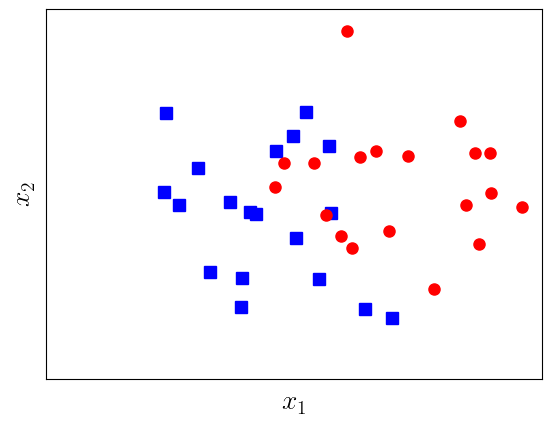

In [10]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals
# list of points 
import numpy as np 
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from matplotlib.backends.backend_pdf import PdfPages
np.random.seed(22)

means = [[2, 2], [4, 2]]
cov = [[.7, 0], [0, .7]]
N = 20
X0 = np.random.multivariate_normal(means[0], cov, N) # each row is a data point 
X1 = np.random.multivariate_normal(means[1], cov, N)

with PdfPages('data.pdf') as pdf:
    plt.plot(X0[:, 0], X0[:, 1], 'bs', markersize = 8, alpha = 1)
    plt.plot(X1[:, 0], X1[:, 1], 'ro', markersize = 8, alpha = 1)
    plt.axis('equal')
    plt.ylim(0, 4)
    plt.xlim(0, 5)

    # hide tikcs 
    cur_axes = plt.gca()
    cur_axes.axes.get_xaxis().set_ticks([])
    cur_axes.axes.get_yaxis().set_ticks([])

    plt.xlabel('$x_1$', fontsize = 20)
    plt.ylabel('$x_2$', fontsize = 20)
    pdf.savefig()
    # plt.savefig('logistic_2d.png', bbox_inches='tight', dpi = 300)
    plt.show()

In [11]:
X = np.vstack((X0, X1))
y = np.vstack((np.ones((N,1 )), -np.ones((N,1 )))).reshape((2*N,))

# Solving by sklearn

In [12]:
from sklearn.svm import SVC
C = 100
clf = SVC(kernel = 'linear', C = C)
clf.fit(X, y) 

w_sklearn = clf.coef_.reshape(-1, 1)
b_sklearn = clf.intercept_[0]

# By dual problems

In [13]:

from cvxopt import matrix, solvers
# build K
V = np.concatenate((X0.T, -X1.T), axis = 1)
K = matrix(V.T.dot(V))

p = matrix(-np.ones((2*N, 1)))
# build A, b, G, h 
G = matrix(np.vstack((-np.eye(2*N), np.eye(2*N))))

h = np.vstack((np.zeros((2*N, 1)), C*np.ones((2*N, 1))))
h = matrix(np.vstack((np.zeros((2*N, 1)), C*np.ones((2*N, 1)))))
A = matrix(y.reshape((-1, 2*N))) 
b = matrix(np.zeros((1, 1))) 
solvers.options['show_progress'] = False
sol = solvers.qp(K, p, G, h, A, b)

l = np.array(sol['x'])
print('lambda = \n', l.T)

lambda = 
 [[1.11381472e-06 9.99999967e+01 1.10533113e-06 6.70163542e-06
  3.40838760e+01 4.73972851e-06 9.99999978e+01 3.13320448e-06
  9.99999985e+01 5.06729333e+01 9.99999929e+01 3.23564235e-06
  9.99999984e+01 9.99999948e+01 1.37977626e-06 9.99997155e+01
  3.45005661e-06 1.46190315e-06 5.50601998e-06 1.45062544e-06
  1.85373848e-06 1.14181647e-06 8.47565685e+01 9.99999966e+01
  9.99999971e+01 8.00764710e-07 2.65537194e-06 1.45230729e-06
  4.15737086e-06 9.99999887e+01 9.99999761e+01 8.98414772e-07
  9.99999979e+01 1.75651608e-06 8.27947898e-07 1.04289117e-06
  9.99999969e+01 9.07920761e-07 8.83138298e-07 9.99999971e+01]]


In [14]:
S = np.where(l > 1e-5)[0]
S2 = np.where(l < .99*C)[0]

M = [val for val in S if val in S2] # intersection of two lists

In [15]:
XT = X.T # we need each col is one data point in this alg
VS = V[:, S]
# XS = XT[:, S]
# yS = y[ S]
lS = l[S]
# lM = l[M]
yM = y[M]
XM = XT[:, M]
w_dual = VS.dot(lS).reshape(-1, 1)
b_dual = np.mean(yM.T - w_dual.T.dot(XM))

# Solving by Hinge loss

In [23]:
X0_bar = np.vstack((X0.T, np.ones((1, N)))) # extended data
X1_bar = np.vstack((X1.T, np.ones((1, N)))) # extended data 

Z = np.hstack((X0_bar, - X1_bar)) # as in (22)
lam = 1./C

def cost(w):
    u = w.T.dot(Z) # as in (23)
    return (np.sum(np.maximum(0, 1 - u)) + \
            .5*lam*np.sum(w*w)) - .5*lam*w[-1]*w[-1]

def grad(w):
    u = w.T.dot(Z) # as in (23)
    H = np.where(u < 1)[1]
    ZS = Z[:, H]
    g = (-np.sum(ZS, axis = 1, keepdims = True) + lam*w)
    g[-1] -= lam*w[-1]
    return g

eps = 1e-6
def num_grad(w):
    g = np.zeros_like(w)
    for i in range(len(w)):
        wp = w.copy()
        wm = w.copy()
        wp[i] += eps 
        wm[i] -= eps 
        g[i] = (cost(wp) - cost(wm))/(2*eps)
    return g 

w0 = np.random.randn(X0_bar.shape[0], 1) 
g1 = grad(w0)
g2 = num_grad(w0)
diff = np.linalg.norm(g1 - g2)
print('Gradient difference: %f' %diff)

Gradient difference: 0.000000


In [25]:
def grad_descent(w0, eta):
    w = w0
    it = 0 
    while it < 100000:
        it = it + 1
        g = grad(w)
        w -= eta*g
        if (it % 10000) == 1:
            print('iter %d' %it + ' cost: %f' %cost(w))
        if np.linalg.norm(g) < 1e-5:
            break 
    return w 
w0 = np.random.randn(X0_bar.shape[0], 1) 
w = grad_descent(w0, 0.001)
w_hinge = w[:-1].reshape(-1, 1)
b_hinge = w[-1]


iter 1 cost: 31.496311
iter 10001 cost: 15.753454
iter 20001 cost: 15.735819
iter 30001 cost: 15.725045
iter 40001 cost: 15.701568
iter 50001 cost: 15.691655
iter 60001 cost: 15.680366
iter 70001 cost: 15.672406
iter 80001 cost: 15.663500
iter 90001 cost: 15.663988


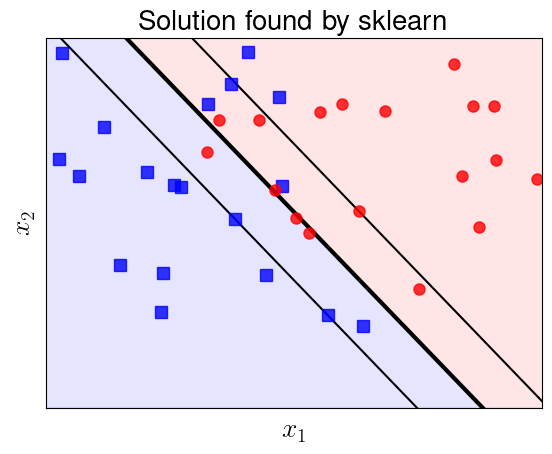

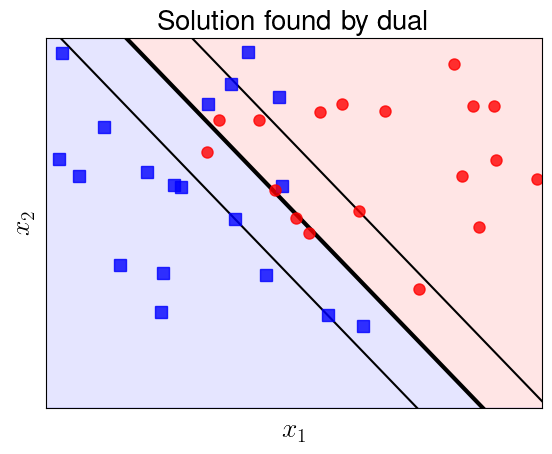

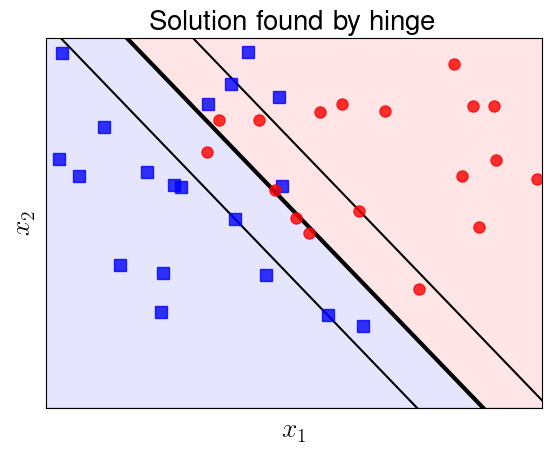

In [27]:
def myplot(X0, X1, w, b, filename, tit):
    with PdfPages(filename) as pdf:
        fig, ax = plt.subplots()

        w0 = w[0]
        w1 = w[1]
        x1 = np.arange(-10, 10, 0.1)
        y1 = -w0/w1*x1 - b/w1
        y2 = -w0/w1*x1 - (b-1)/w1
        y3 = -w0/w1*x1 - (b+1)/w1
        plt.plot(x1, y1, 'k', linewidth = 3)
        plt.plot(x1, y2, 'k')
        plt.plot(x1, y3, 'k')

        # equal axis and lim
        plt.axis('equal')
        plt.ylim(0, 3)
        plt.xlim(2, 4)

        # hide tikcs 
        cur_axes = plt.gca()
        cur_axes.axes.get_xaxis().set_ticks([])
        cur_axes.axes.get_yaxis().set_ticks([])

        # fill two regions
        y4 = 10*x1
        plt.plot(x1, y1, 'k')
        plt.fill_between(x1, y1, color='blue', alpha=0.1)
        plt.fill_between(x1, y1, y4, color = 'red', alpha = .1)

        plt.xlabel('$x_1$', fontsize = 20)
        plt.ylabel('$x_2$', fontsize = 20)
        plt.title('Solution found by ' + tit, fontsize = 20)

        plt.plot(X0[:, 0], X0[:, 1], 'bs', markersize = 8, alpha = .8)
        plt.plot(X1[:, 0], X1[:, 1], 'ro', markersize = 8, alpha = .8)
        pdf.savefig()
        plt.show()

myplot(X0, X1, w_sklearn, b_sklearn, 'svm_sklearn.pdf', 'sklearn')
myplot(X0, X1, w_dual, b_dual, 'svm_dual.pdf', 'dual')
myplot(X0, X1, w_hinge, b_hinge, 'svm_hinge.pdf', 'hinge')

In [28]:
print(w_sklearn.T, b_sklearn)
print(w_dual.T, b_dual) 
print(w_hinge.T, b_hinge)

[[-1.87461946 -1.80697358]] 8.496911901960104
[[-1.87457279 -1.80695039]] 8.496721098143148
[[-1.86302666 -1.79478804]] [8.45016304]
